In [138]:
import gc

gc.collect()

0

In [139]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT
# Any results you write to the current directory are saved as output.


timestamp_Frequency = ['Weekly'] #'month'
if timestamp_Frequency[0] == 'Weekly':
    season_number_of_points = 52
    forecastingHorizon = 26
else:
    season_number_of_points = 12
    forecastingHorizon = 6
patience = 25

sp = season_number_of_points
timestamp = season_number_of_points
train_ratio = 0.5
if train_ratio < 0.5 :
    train_ratio = 0.5
usePipe = True #False is currently broken
useValidation = True
progressiveForecast = True

# datasetList = ['AirPassengers.csv','AirPassengers.csv']
# datasetList = ["12141","18805","25472","26855","72758","90833","197456","566393"]
#"74826"
datasetList = ["75038","85843","85861","86040","86543","121216","121397","121457","197456","253059","268987","269221","271177",
"271179","370801","417538","417622","424390","424391","424479","534571","545488","546924","566393","566394","566395", "566409"]


if (progressiveForecast):
    indirectForecastingHorizon = forecastingHorizon
    forecastingHorizon = 1
    realForecastingHorizon = indirectForecastingHorizon
else:
    realForecastingHorizon = forecastingHorizon

In [140]:
if (usePipe):
    print(len(datasetList))
    pipeTrain = list([])
    pipeTest = list([])
    for i in range (len(datasetList)):
        pipeTrain.append(TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
        ]))
        pipeTest.append(TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
        ]))
else :
    scalerTrain = list([])
    scalerTest = list([])
    for i in range (len(datasetList)):
        scalerTrain.append(MinMaxScaler(feature_range=(0,1)))
        scalerTest.append(MinMaxScaler(feature_range=(0,1)))
# print(pipeTrain)

27


In [204]:
for idxdataset, datasetName in enumerate(datasetList):
    datasetTarget="/home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/Data/correctedsupplyProduct_"+datasetName+".csv"
    df = pd.read_csv(datasetTarget, header=0, index_col=0)
    df.reset_index(inplace=True)
    # print(df.head())
    dataset = df.iloc[:,1].values
    # if (datasetName == "75038" or datasetName == "85843" or datasetName == "85861"):
    #     print(dataset)
    #     plt.plot(dataset)
    #     plt.show
    train_size = int(len(dataset)*train_ratio)
    test_size = len(dataset) - train_size
    # print("train_size : ",train_size,"test_size : ",test_size)
    if (train_ratio == 0.5 and train_size != test_size):
        test_size = min(test_size,train_size) 
        train_size = min(test_size,train_size)
    trainDataset = dataset[:train_size]
    testDataset = dataset[train_size:train_size+test_size]
    # print(len(trainDataset))
    # print(len(testDataset))
    len_of_trainDataset = len(trainDataset)-timestamp-forecastingHorizon+1
    len_of_testDataset = len(testDataset)-timestamp-forecastingHorizon+1
    len_of_trainDataset_indirect = len(trainDataset)-timestamp-indirectForecastingHorizon+1
    len_of_testDataset_indirect = len(testDataset)-timestamp-indirectForecastingHorizon+1
    if (idxdataset == 0):
        # print(len_of_trainDataset, min_len_of_trainDataset, datasetName)
        max_len_of_trainDataset = len_of_trainDataset
        min_len_of_trainDataset = len_of_trainDataset
        max_len_of_testDataset = len_of_testDataset
        min_len_of_testDataset = len_of_testDataset
        max_len_of_trainDataset_indirect = len_of_trainDataset_indirect
        min_len_of_trainDataset_indirect = len_of_trainDataset_indirect
        max_len_of_testDataset_indirect = len_of_testDataset_indirect
        min_len_of_testDataset_indirect = len_of_testDataset_indirect

    else:
        # print("else",min_len_of_testDataset_indirect, min_len_of_testDataset_indirect,max_len_of_testDataset_indirect, datasetName)
        if (len_of_trainDataset < min_len_of_trainDataset):
            min_len_of_trainDataset = len_of_trainDataset
        if (len_of_trainDataset > max_len_of_trainDataset):
            max_len_of_trainDataset = len_of_trainDataset
        if (len_of_testDataset < min_len_of_trainDataset):
            min_len_of_trainDataset = len_of_testDataset
        if (len_of_testDataset > max_len_of_trainDataset):
            max_len_of_trainDataset = len_of_testDataset
        if (len_of_trainDataset_indirect < min_len_of_trainDataset_indirect):
            min_len_of_trainDataset_indirect = len_of_trainDataset_indirect
        if (len_of_trainDataset_indirect > max_len_of_trainDataset_indirect):
            max_len_of_trainDataset = len_of_trainDataset_indirect
        if (len_of_testDataset_indirect < min_len_of_testDataset_indirect):
            min_len_of_testDataset_indirect = len_of_testDataset_indirect
        if (len_of_testDataset_indirect > max_len_of_testDataset_indirect):
            max_len_of_testDataset_indirect = len_of_testDataset_indirect
print("min_len_of_trainDataset ",min_len_of_trainDataset)
print("max_len_of_trainDataset ",max_len_of_trainDataset)
print("min_len_of_testDataset ",min_len_of_testDataset)
print("max_len_of_testDataset ",max_len_of_testDataset)
print("min_len_of_trainDataset_indirect ",min_len_of_trainDataset_indirect)
print("max_len_of_trainDataset_indirect ",max_len_of_trainDataset_indirect)
print("min_len_of_testDataset_indirect ",min_len_of_testDataset_indirect)
print("max_len_of_testDataset_indirect ",max_len_of_testDataset_indirect)

min_len_of_trainDataset  50
max_len_of_trainDataset  50
min_len_of_testDataset  50
max_len_of_testDataset  50
min_len_of_trainDataset_indirect  25
max_len_of_trainDataset_indirect  25
min_len_of_testDataset_indirect  25
max_len_of_testDataset_indirect  25


In [211]:
fullDataset = list([])
for idxdataset, datasetName in enumerate(datasetList):
    # print("New dataset : ",datasetName)
#     df = pd.read_csv(datasetName,parse_dates = timestamp_Frequency)
    datasetTarget="/home/esteban/Documents/Optimix/Projet_LSTM_Keras_C++/Data/correctedsupplyProduct_"+datasetName+".csv"
    df = pd.read_csv(datasetTarget, header=0, index_col=0)
    df.reset_index(inplace=True)
    # df.head()
    dataset = df.iloc[:,1].values
    train_size = int(len(dataset)*train_ratio)
    test_size = len(dataset) - train_size
    if (train_ratio == 0.5 and train_size != test_size):
        test_size = min(test_size,train_size) 
        train_size = min(test_size,train_size)
    trainDataset = dataset[:train_size]
    testDataset = dataset[train_size:train_size+test_size]

#     fullDataset = np.append(fullDataset, dataset,axis=0)
#     print("fullDataset = ",fullDataset, type (fullDataset), dataset, type(dataset))
    fullDataset.append(dataset)
#     print("fullDataset = ",[fullDataset])
#     plt.xlabel('time')
#     plt.ylabel('number of passengers')
#     plt.title('International Airline Passenger')
    # plt.show()

    # print("idxdataset ",idxdataset)
    print('train_size : {}, test_size : {}, total_size : {}'.format(len(trainDataset),len(testDataset),len(trainDataset)+len(testDataset)))
    if (idxdataset == 0):
        # len_of_trainDataset = len(trainDataset)-timestamp-forecastingHorizon+1
        # len_of_testDataset = len(testDataset)-timestamp-forecastingHorizon+1
        # len_of_trainDataset_indirect = len(trainDataset)-timestamp-indirectForecastingHorizon+1
        # len_of_testDataset_indirect = len(testDataset)-timestamp-indirectForecastingHorizon+1
        len_of_trainDataset = min_len_of_trainDataset
        len_of_testDataset = min(min_len_of_testDataset,min_len_of_trainDataset)
        len_of_trainDataset_indirect = min_len_of_trainDataset_indirect
        len_of_testDataset_indirect = min(min_len_of_testDataset_indirect,len_of_trainDataset_indirect)
        # print("len_of_trainDataset : ",len_of_trainDataset, " len_of_testDataset : ",len_of_testDataset, "len_of_trainDataset_indirect : ",len_of_trainDataset_indirect,"len_of_testDataset_indirect : ",len_of_testDataset_indirect)
        transformedTrainDatasetInputs = np.empty((0,len_of_trainDataset,timestamp))
        transformedTrainDatasetOutputs = np.empty((0,len_of_trainDataset,forecastingHorizon))
        transformedTestDatasetInputs = np.empty((0,len_of_testDataset,timestamp))
        transformedTestDatasetOutputs = np.empty((0,len_of_testDataset,forecastingHorizon))
        if (progressiveForecast):
            indirectTransformedTrainDatasetInputs = np.empty((0,len_of_trainDataset_indirect,timestamp))
            indirectTransformedTrainDatasetOutputs = np.empty((0,len_of_trainDataset_indirect,indirectForecastingHorizon))
            indirectTransformedTestDatasetInputs = np.empty((0,len_of_testDataset_indirect,timestamp))
            indirectTransformedTestDatasetOutputs = np.empty((0,len_of_testDataset_indirect,indirectForecastingHorizon))

    if (usePipe):
        transformedTrainDataset = pipeTrain[idxdataset].fit_transform(trainDataset)
        transformedTestDataset = pipeTest[idxdataset].fit_transform(testDataset)
#         print("test fitted 0", pipeTrain[0].check_is_fitted())
#         print("test fitted 1", pipeTrain[1].check_is_fitted())
#         print("test fitted 2", pipeTrain[2].check_is_fitted())
#         print("test fitted 3", pipeTrain[3].check_is_fitted())
#         print("test fitted 4", pipeTrain[4].check_is_fitted())
#         print("test fitted 5", pipeTrain[5].check_is_fitted())
    else:
        transformedTrainDataset = scalerTrain[idxdataset].fit_transform(trainDataset.reshape(-1, 1))
        transformedTestDataset = scalerTest[idxdataset].fit_transform(testDataset.reshape(-1, 1))

#     print("transformedTrainDataset : ", transformedTrainDataset.shape, "transformedTestDataset : ", transformedTestDataset.shape)
    dataX = []
    dataY = []
    # print(len(transformedTrainDataset),len(transformedTestDataset))
    for i in range(len(transformedTrainDataset)-timestamp-forecastingHorizon+1):
        a = transformedTrainDataset[i:(i+timestamp),0]
        b = transformedTrainDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
        dataX.append(a)
        dataY.append(b)
    transformedTrainDatasetInputs = np.concatenate((transformedTrainDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
    transformedTrainDatasetOutputs = np.concatenate((transformedTrainDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
    # print("transformedTrainDatasetInputs : ", transformedTrainDatasetInputs.shape, "transformedTrainDatasetOutputs : ", transformedTrainDatasetOutputs.shape)
    
    dataX = []
    dataY = []
    if(len(transformedTestDataset)-timestamp-forecastingHorizon+1)<=0:
        print( "Error : dataset size")
    for i in range(len(transformedTestDataset)-timestamp-forecastingHorizon+1):
        a = transformedTestDataset[i:(i+timestamp),0]
        b = transformedTestDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
        dataX.append(a)
        dataY.append(b)
    transformedTestDatasetInputs = np.concatenate((transformedTestDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
    transformedTestDatasetOutputs = np.concatenate((transformedTestDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
    # print("transformedTestDatasetInputs : ", transformedTestDatasetInputs.shape, "transformedTestDatasetOutputs : ", transformedTestDatasetOutputs.shape)

    if (progressiveForecast):
        dataX = []
        dataY = []
        for i in range(len(transformedTrainDataset)-timestamp-indirectForecastingHorizon+1):
            a = transformedTrainDataset[i:(i+timestamp),0]
            b = transformedTrainDataset[(i+timestamp):(i+timestamp+indirectForecastingHorizon),0]
            dataX.append(a)
            dataY.append(b)
        indirectTransformedTrainDatasetInputs = np.concatenate((indirectTransformedTrainDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
        indirectTransformedTrainDatasetOutputs = np.concatenate((indirectTransformedTrainDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
        # print("indirectTransformedTrainDatasetInputs : ", indirectTransformedTrainDatasetInputs.shape, "indirectTransformedTrainDatasetOutputs : ", indirectTransformedTrainDatasetOutputs.shape)
        
        dataX = []
        dataY = []
        for i in range(len(transformedTestDataset)-timestamp-indirectForecastingHorizon+1):
            a = transformedTestDataset[i:(i+timestamp),0]
            # print("a ",a)
            b = transformedTestDataset[(i+timestamp):(i+timestamp+indirectForecastingHorizon),0]
            dataX.append(a)
            dataY.append(b)
        # print(indirectTransformedTestDatasetInputs.shape, np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1]).shape)
        indirectTransformedTestDatasetInputs = np.concatenate((indirectTransformedTestDatasetInputs,np.array(dataX).reshape(1,np.array(dataX).shape[0],np.array(dataX).shape[1])),axis=0)
        indirectTransformedTestDatasetOutputs = np.concatenate((indirectTransformedTestDatasetOutputs,np.array(dataY).reshape(1,np.array(dataY).shape[0],np.array(dataY).shape[1])),axis=0)
        # print("indirectTransformedTestDatasetInputs : ", indirectTransformedTestDatasetInputs.shape, "indirectTransformedTestDatasetOutputs : ", indirectTransformedTestDatasetOutputs.shape)
    print("pipetrainlen",len(pipeTrain))
    print("pipetestlen",len(pipeTest))

train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
train_size : 102, test_size : 102, total_size : 204
pipetrainlen 27
pipetestlen 27
trai

In [212]:
print('transformedTrainDatasetInputs shape : {}, transformedTestDatasetInputs original shape : {}'.format(transformedTrainDatasetInputs.shape,transformedTestDatasetInputs.shape))
print('transformedTrainDatasetOutputs shape : {}, transformedTestDatasetOutputs original shape : {}'.format(transformedTrainDatasetOutputs.shape,transformedTestDatasetOutputs.shape))

reshapedTransformedTrainDatasetInputs = np.reshape(transformedTrainDatasetInputs,(-1,1,transformedTrainDatasetInputs.shape[2])) #(number of points, features number, lookback)
reshapedTransformedTestDatasetInputs = np.reshape(transformedTestDatasetInputs,(-1,1,transformedTestDatasetInputs.shape[2]))

reshapedTransformedTrainDatasetOutputs = np.reshape(transformedTrainDatasetOutputs,(-1,transformedTrainDatasetOutputs.shape[2])) #(number of points, features number, lookback)
reshapedTransformedTestDatasetOutputs = np.reshape(transformedTestDatasetOutputs,(-1,transformedTestDatasetOutputs.shape[2]))

if (progressiveForecast):
    print(indirectTransformedTestDatasetOutputs.shape)
    reshapedIndirectTransformedTestDatasetOutputs = np.reshape(indirectTransformedTestDatasetOutputs,(-1,indirectTransformedTestDatasetOutputs.shape[2]))
print('\nreshapedTransformedTrainDatasetInputs shape : {}, reshapedTransformedTestDatasetInputs shape : {}'.format(reshapedTransformedTrainDatasetInputs.shape,reshapedTransformedTestDatasetInputs.shape))
print('reshapedTransformedTrainDatasetOutputs shape : {}, reshapedTransformedTestDatasetOutputs shape : {}'.format(reshapedTransformedTrainDatasetOutputs.shape,reshapedTransformedTestDatasetOutputs.shape))

#IMPORTANT : FORMAT IS (NUMBER OF TIME SERIES, NUMBER OF INPUTS COMBINATIONS, SIZE OF INPUT)

transformedTrainDatasetInputs shape : (27, 50, 52), transformedTestDatasetInputs original shape : (27, 50, 52)
transformedTrainDatasetOutputs shape : (27, 50, 1), transformedTestDatasetOutputs original shape : (27, 50, 1)
(27, 25, 26)

reshapedTransformedTrainDatasetInputs shape : (1350, 1, 52), reshapedTransformedTestDatasetInputs shape : (1350, 1, 52)
reshapedTransformedTrainDatasetOutputs shape : (1350, 1), reshapedTransformedTestDatasetOutputs shape : (1350, 1)


Train on 1350 samples, validate on 1350 samples
Epoch 1/100
1349/1350 [============================>.] - ETA: 0s - loss: 0.0961

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1350/1350 [==============================] - 6s 4ms/sample - loss: 0.0960 - val_loss: 0.0474
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/sample - loss: 0.0494 - val_loss: 0.0468
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/sample - loss: 0.0472 - val_loss: 0.0463
Epoch 4/100
1350/1350 [==============================] - 5s 3ms/sample - loss: 0.0459 - val_loss: 0.0459
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/sample - loss: 0.0447 - val_loss: 0.0444
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/sample - loss: 0.0436 - val_loss: 0.0436
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/sample - loss: 0.0426 - val_loss: 0.0430
Epoch 8/100
1350/1350 [==============================] - 5s 4ms/sample - loss: 0.0417 - val_loss: 0.0429
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/sample - loss: 0.0409 - val_loss: 0.0422
Epoch 10/100
1350/1350 [==============================] - 5s 4ms/sa

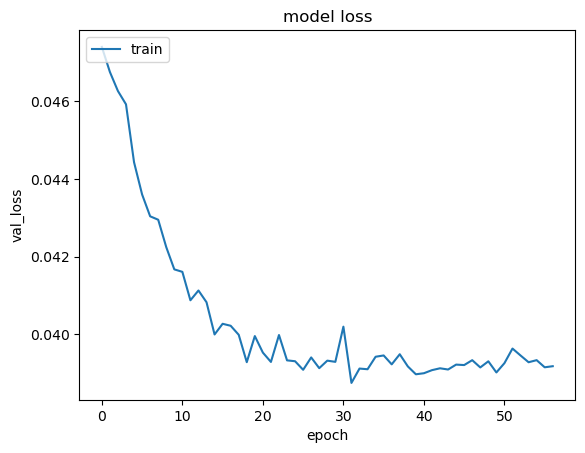

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                10880     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,913
Trainable params: 10,913
Non-trainable params: 0
_________________________________________________________________
None


In [213]:
# print(trainY.shape[2])
# model
model = Sequential()
# model.add(Dense(32))
# model.add(LSTM(32)) # 10 lstm neuron(block)
model.add(LSTM(32, input_shape=(1, timestamp))) # 10 lstm neuron(block)
model.add(Dense(forecastingHorizon))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)) #'adam'
# history = model.fit(trainX, trainY, epochs=50, batch_size=1)
# print(model.output_shape)
if (useValidation):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.00005)
    ]
    history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=100, batch_size=1, validation_data=(reshapedTransformedTestDatasetInputs,reshapedTransformedTestDatasetOutputs), callbacks=callbacks)
    plt.title('model loss')
    try :
        plt.plot(history.history['val_loss'])
        plt.ylabel('val_loss')
    except : 
        plt.plot(history.history['loss'])
        plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
else :
    callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.00005)
    ]
    history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=100, batch_size=1, callbacks=callbacks)
    plt.title('model loss')
    plt.plot(history.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
# tf.keras.utils.plot_model(model, show_shapes=True)
print(model.summary())

In [214]:
if (progressiveForecast):
    # print(indirectTransformedTrainDatasetInputs.shape)
    # print(indirectTransformedTrainDatasetInputs.shape[1])
    finalTrainPredictionOutput = [[[np.nan for k in range(indirectForecastingHorizon)] for j in range(indirectTransformedTrainDatasetInputs.shape[1])] for i in range(len(datasetList))]
    finalTestPredictionOutput = [[[np.nan for k in range(indirectForecastingHorizon)] for j in range(indirectTransformedTestDatasetInputs.shape[1])] for i in range(len(datasetList))]
    for idxdataset, datasetName in enumerate(datasetList):
        for indexTimeSerie in range (0,indirectTransformedTrainDatasetInputs.shape[1]):
            currentInputsArray = indirectTransformedTrainDatasetInputs[idxdataset][indexTimeSerie]
            predictionOutput = []
            for i in range (0,indirectForecastingHorizon,1):
                currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
                currentInputsArray = np.delete(currentInputsArray, 0)
                currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
                predictionOutput.append(currentOutput[0][0])
            finalTrainPredictionOutput[idxdataset][indexTimeSerie] = predictionOutput
        for indexTimeSerie in range (0,indirectTransformedTestDatasetInputs.shape[1]):
            currentInputsArray = indirectTransformedTestDatasetInputs[idxdataset][indexTimeSerie]
            predictionOutput = []
            for i in range (0,indirectForecastingHorizon,1):
                currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
                currentInputsArray = np.delete(currentInputsArray, 0)
                currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
                predictionOutput.append(currentOutput[0][0])
            finalTestPredictionOutput[idxdataset][indexTimeSerie] = predictionOutput
    transformedTrainDatasetPredictions = np.array(finalTrainPredictionOutput)
    transformedTestDatasetPredictions = np.array(finalTestPredictionOutput)

    print("Progressive Forecasting has been used")
else :
    transformedTrainDatasetPredictions = model.predict(reshapedTransformedTrainDatasetInputs).reshape(len(fullDataset),-1,forecastingHorizon)
    transformedTestDatasetPredictions = model.predict(reshapedTransformedTestDatasetInputs).reshape(len(fullDataset),-1,forecastingHorizon)

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Progressive Forecasting has been used


In [215]:
print("transformedTrainDatasetPredictions : ", transformedTrainDatasetPredictions.shape, "transformedTestDatasetPredictions : ", transformedTestDatasetPredictions.shape)

if usePipe :
    TrainDatasetInputs = np.empty((0,transformedTrainDatasetInputs.shape[1],timestamp))
    TrainDatasetOutputs = np.empty((0,transformedTrainDatasetOutputs.shape[1],forecastingHorizon))
    TrainDatasetPredictions = np.empty((0,transformedTrainDatasetPredictions.shape[1],realForecastingHorizon))
    TestDatasetInputs = np.empty((0,transformedTestDatasetInputs.shape[1],timestamp))
    TestDatasetOutputs = np.empty((0,transformedTestDatasetInputs.shape[1],forecastingHorizon))
    TestDatasetPredictions = np.empty((0,transformedTestDatasetPredictions.shape[1],realForecastingHorizon))
    for (idx, dataset) in enumerate(datasetList) :
        print("\nValues for Dataset ",idx)
        trainInputsRange = reshapedTransformedTrainDatasetInputs[idx*transformedTrainDatasetInputs.shape[1]:(idx+1)*transformedTrainDatasetInputs.shape[1]].reshape(-1,1)
        TrainDatasetInputs = np.append(TrainDatasetInputs,pipeTrain[idx].inverse_transform(trainInputsRange).reshape(1,-1,timestamp), axis = 0)
        print("Train Inputs Shape : ", TrainDatasetInputs.shape)
        
        trainOutputsRange = reshapedTransformedTrainDatasetOutputs[idx*transformedTrainDatasetOutputs.shape[1]:(idx+1)*transformedTrainDatasetOutputs.shape[1]].reshape(-1,1)
        TrainDatasetOutputs = np.append(TrainDatasetOutputs, pipeTrain[idx].inverse_transform(trainOutputsRange).reshape(1,-1,forecastingHorizon), axis = 0)
        print("Train Outputs Shape : ", TrainDatasetOutputs.shape)
        
        trainPredictionsRange = (transformedTrainDatasetPredictions.reshape(-1,1)[idx*transformedTrainDatasetPredictions.shape[1]*transformedTrainDatasetPredictions.shape[2]:(idx+1)*transformedTrainDatasetPredictions.shape[1]*transformedTrainDatasetPredictions.shape[2]])
        TrainDatasetPredictions = np.append(TrainDatasetPredictions, pipeTrain[idx].inverse_transform(trainPredictionsRange).reshape(1,-1,realForecastingHorizon), axis = 0)
        print("Train Predictions Shape : ", TrainDatasetPredictions.shape)

        testInputsRange = reshapedTransformedTestDatasetInputs.reshape(-1,1)[idx*timestamp*transformedTestDatasetInputs.shape[1]:(idx+1)*timestamp*transformedTestDatasetInputs.shape[1]]
        TestDatasetInputs = np.append(TestDatasetInputs, pipeTest[idx].inverse_transform(testInputsRange).reshape(1,-1,timestamp),axis=0)
        print("Test Inputs Shape : ", TestDatasetInputs.shape)
        
        if (progressiveForecast):
            testOutputsRange = reshapedTransformedTestDatasetOutputs[idx*transformedTestDatasetOutputs.shape[1]:(idx+1)*transformedTestDatasetOutputs.shape[1]].reshape(-1,1)
            TestDatasetOutputs = np.append(TestDatasetOutputs, pipeTest[idx].inverse_transform(testOutputsRange).reshape(1,-1,forecastingHorizon),axis=0)
            print("Test Outputs Shape : ", TestDatasetOutputs.shape)
            
            testPredictionsRange = (transformedTestDatasetPredictions.reshape(-1,1)[idx*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]:(idx+1)*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]])
            print(TestDatasetPredictions.shape, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,forecastingHorizon).shape)
            TestDatasetPredictions = np.append(TestDatasetPredictions, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,realForecastingHorizon), axis = 0)
            print("Test Predictions Shape : ", TestDatasetPredictions.shape)
        else:
#             print("range ", np.array(reshapedTransformedTestDatasetOutputs).shape)
            testOutputsRange = reshapedTransformedTestDatasetOutputs[idx*transformedTestDatasetOutputs.shape[1]:(idx+1)*transformedTestDatasetOutputs.shape[1]].reshape(-1,1)
            TestDatasetOutputs = np.append(TestDatasetOutputs, pipeTest[idx].inverse_transform(testOutputsRange).reshape(1,-1,forecastingHorizon),axis=0)
            print("Test Outputs Shape : ", TestDatasetOutputs.shape)
            testPredictionsRange = transformedTestDatasetPredictions.reshape(-1,1)[idx*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]:(idx+1)*transformedTestDatasetPredictions.shape[1]*transformedTestDatasetPredictions.shape[2]]
            TestDatasetPredictions = np.append(TestDatasetPredictions, pipeTest[idx].inverse_transform(testPredictionsRange).reshape(1,-1,forecastingHorizon),axis=0)
            print("Test Predictions Shape : ", TestDatasetPredictions.shape)
            # TrainDatasetOutputs = TrainDatasetOutputs.reshape(TrainDatasetOutputs.shape[0],TrainDatasetOutputs.shape[2],TrainDatasetOutputs.shape[1])
            # TrainDatasetPredictions = TrainDatasetPredictions.reshape(TrainDatasetPredictions.shape[0],TrainDatasetPredictions.shape[2],TrainDatasetPredictions.shape[1])


else :
    for (idx, dataset) in enumerate(datasetList) :     
        TrainDatasetInputs = scalerTrain[idx].inverse_transform(reshapedTransformedTrainDatasetInputs.reshape(-1,1)).reshape(len(fullDataset),-1,timestamp)
        TrainDatasetOutputs = scalerTrain[idx].inverse_transform(reshapedTransformedTrainDatasetOutputs.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
        TrainDatasetPredictions = scalerTrain[idx].inverse_transform(transformedTrainDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
        TestDatasetInputs = scalerTest[idx].inverse_transform(reshapedTransformedTestDatasetInputs.reshape(-1,1)).reshape(len(fullDataset),-1,timestamp)
        if (progressiveForecast):
            TestDatasetOutputs = scalerTest[idx].inverse_transform(np.array(reshapedIndirectTransformedTestDatasetOutputs).reshape(-1,1)).reshape(len(fullDataset),-1,indirectForecastingHorizon)
            TestDatasetPredictions = scalerTest[idx].inverse_transform(transformedTestDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,indirectForecastingHorizon)
        else : 
            TestDatasetOutputs = scalerTest[idx].inverse_transform(reshapedTransformedTestDatasetOutputs.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)
            TestDatasetPredictions = scalerTest[idx].inverse_transform(transformedTestDatasetPredictions.reshape(-1,1)).reshape(len(fullDataset),-1,forecastingHorizon)

print(TrainDatasetInputs.shape, TrainDatasetOutputs.shape, TrainDatasetPredictions.shape, TestDatasetInputs.shape, TestDatasetOutputs.shape, TestDatasetPredictions.shape)
#doit être (nombre de dataset, nombre de combinaisons, timestamp)

transformedTrainDatasetPredictions :  (27, 25, 26) transformedTestDatasetPredictions :  (27, 25, 26)

Values for Dataset  0
Train Inputs Shape :  (1, 50, 52)
Train Outputs Shape :  (1, 50, 1)
Train Predictions Shape :  (1, 25, 26)
Test Inputs Shape :  (1, 50, 52)
Test Outputs Shape :  (1, 50, 1)
(0, 25, 26) (1, 650, 1)
Test Predictions Shape :  (1, 25, 26)

Values for Dataset  1
Train Inputs Shape :  (2, 50, 52)
Train Outputs Shape :  (2, 50, 1)
Train Predictions Shape :  (2, 25, 26)
Test Inputs Shape :  (2, 50, 52)
Test Outputs Shape :  (2, 50, 1)
(1, 25, 26) (1, 650, 1)
Test Predictions Shape :  (2, 25, 26)

Values for Dataset  2
Train Inputs Shape :  (3, 50, 52)
Train Outputs Shape :  (3, 50, 1)
Train Predictions Shape :  (3, 25, 26)
Test Inputs Shape :  (3, 50, 52)
Test Outputs Shape :  (3, 50, 1)
(2, 25, 26) (1, 650, 1)
Test Predictions Shape :  (3, 25, 26)

Values for Dataset  3
Train Inputs Shape :  (4, 50, 52)
Train Outputs Shape :  (4, 50, 1)
Train Predictions Shape :  (4, 25,

In [216]:
if (progressiveForecast):
    TrainDatasetOutputs = TrainDatasetOutputs.reshape(TrainDatasetOutputs.shape[0],TrainDatasetOutputs.shape[2],TrainDatasetOutputs.shape[1])
    TestDatasetOutputs = TestDatasetOutputs.reshape(TestDatasetOutputs.shape[0],TestDatasetOutputs.shape[2],TestDatasetOutputs.shape[1])
#     print("TrainDatasetOutputs ", TrainDatasetOutputs.shape, "TestDatasetOutputs " ,TestDatasetOutputs.shape)
# TrainDatasetOutputs

In [222]:

#     TrainDatasetPredictions = TrainDatasetPredictions.reshape(TrainDatasetPredictions.shape[0],TrainDatasetPredictions.shape[2],TrainDatasetPredictions.shape[1])
# print(TrainDatasetOutputs[0])
# print(TrainDatasetOutputs[1])
# print(TrainDatasetOutputs[2])
# print(TrainDatasetOutputs[idx][0].shape)
# print(TrainDatasetPredictions[idx][0].shape)
for (idx, dataset) in enumerate(datasetList) : 
    print("\nValues for Dataset ",idx)
    print(TrainDatasetOutputs[idx][0:indirectForecastingHorizon].shape,TrainDatasetPredictions[idx][0].shape)
    trainScore = math.sqrt(mean_squared_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(TestDatasetOutputs[idx][0][0:realForecastingHorizon], TestDatasetPredictions[idx][0]))
    print('Test Score: %.2f RMSE' % (testScore))
    trainScore2 = math.sqrt(mean_absolute_percentage_error(TrainDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Train Score: %.2f MAPE' % (trainScore2))
    testScore2 = math.sqrt(mean_absolute_percentage_error(TestDatasetOutputs[idx][0][0:realForecastingHorizon], TrainDatasetPredictions[idx][0]))
    print('Test Score: %.2f MAPE' % (testScore2))


Values for Dataset  0
(1, 50) (26,)
Train Score: 19.15 RMSE
Test Score: 12.70 RMSE
Train Score: 0.66 MAPE
Test Score: 0.69 MAPE

Values for Dataset  1
(1, 50) (26,)
Train Score: 556.18 RMSE
Test Score: 65.60 RMSE
Train Score: 0.65 MAPE
Test Score: 0.57 MAPE

Values for Dataset  2
(1, 50) (26,)
Train Score: 705.05 RMSE
Test Score: 188.98 RMSE
Train Score: 0.78 MAPE
Test Score: 0.86 MAPE

Values for Dataset  3
(1, 50) (26,)
Train Score: 58.95 RMSE
Test Score: 50.17 RMSE
Train Score: 0.63 MAPE
Test Score: 1.55 MAPE

Values for Dataset  4
(1, 50) (26,)
Train Score: 23.12 RMSE
Test Score: 27.80 RMSE
Train Score: 0.58 MAPE
Test Score: 1.13 MAPE

Values for Dataset  5
(1, 50) (26,)
Train Score: 32.66 RMSE
Test Score: 42.74 RMSE
Train Score: 0.49 MAPE
Test Score: 0.82 MAPE

Values for Dataset  6
(1, 50) (26,)
Train Score: 87.66 RMSE
Test Score: 60.87 RMSE
Train Score: 0.52 MAPE
Test Score: 1.07 MAPE

Values for Dataset  7
(1, 50) (26,)
Train Score: 236.11 RMSE
Test Score: 72.11 RMSE
Train Sco

DATASET INDEX  0
DATASET NUMBER  75038


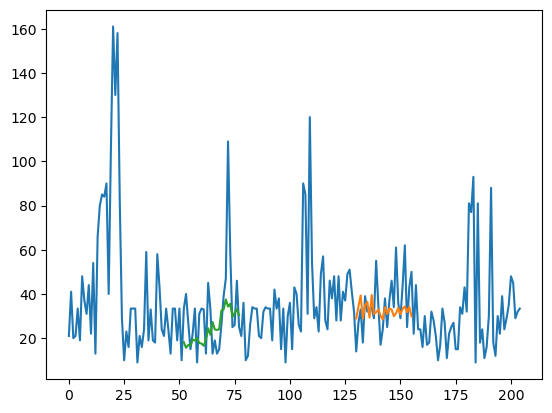

NEXT
DATASET INDEX  1
DATASET NUMBER  85843


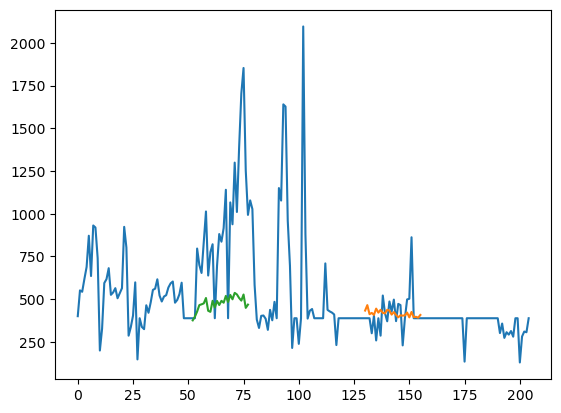

NEXT
DATASET INDEX  2
DATASET NUMBER  85861


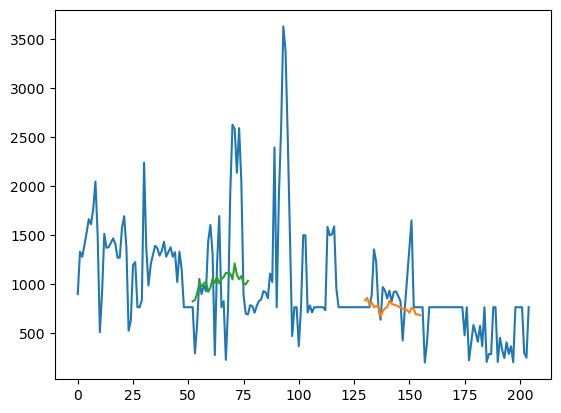

NEXT
DATASET INDEX  3
DATASET NUMBER  86040


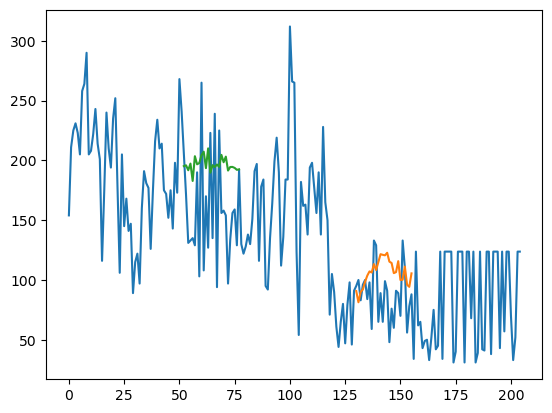

NEXT
DATASET INDEX  4
DATASET NUMBER  86543


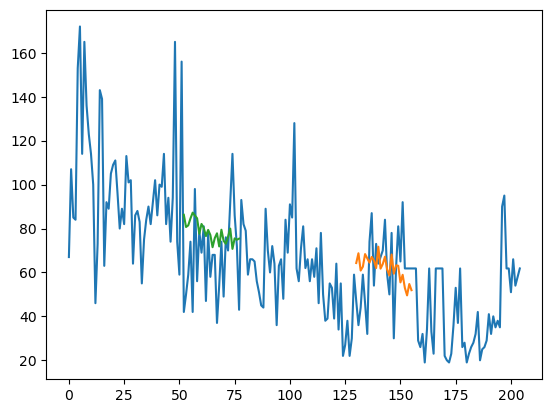

NEXT
DATASET INDEX  5
DATASET NUMBER  121216


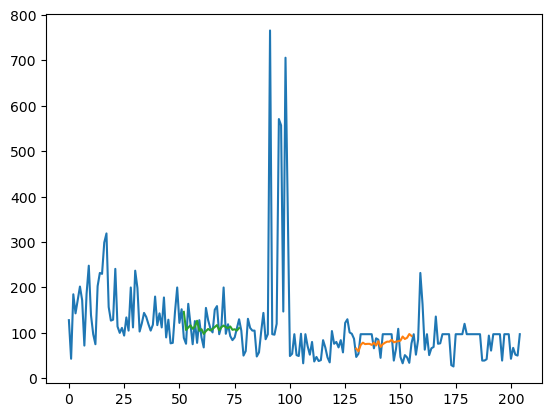

NEXT
DATASET INDEX  6
DATASET NUMBER  121397


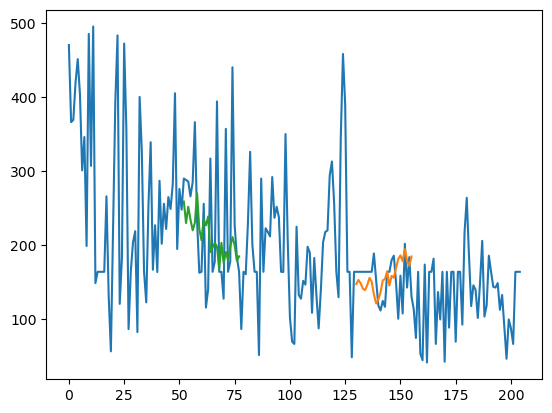

NEXT
DATASET INDEX  7
DATASET NUMBER  121457


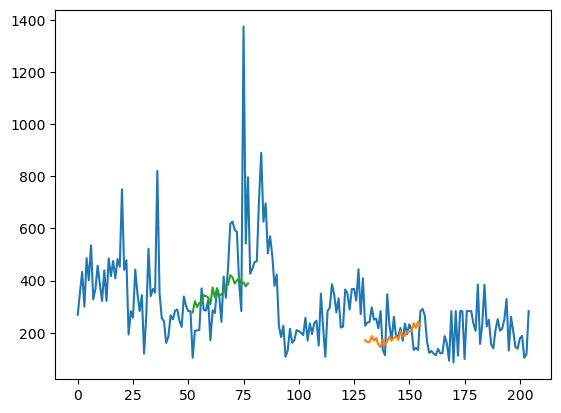

NEXT
DATASET INDEX  8
DATASET NUMBER  197456


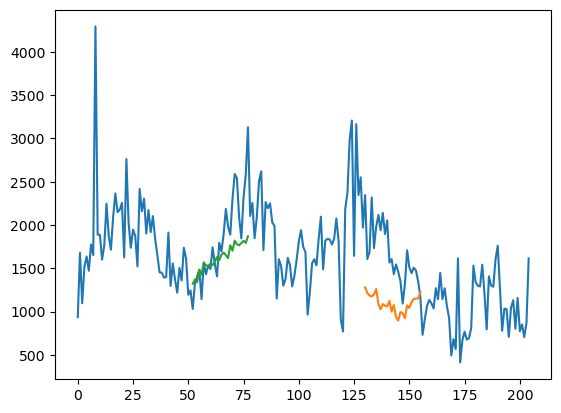

NEXT
DATASET INDEX  9
DATASET NUMBER  253059


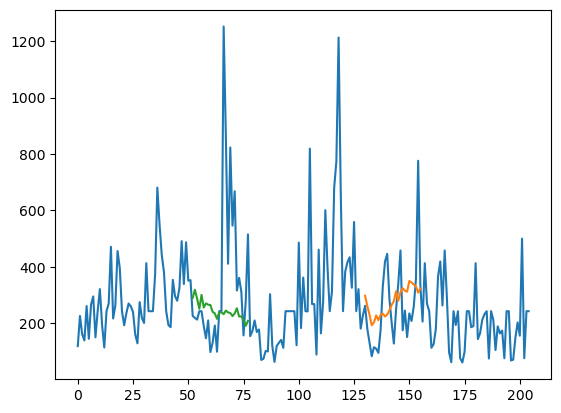

NEXT
DATASET INDEX  10
DATASET NUMBER  268987


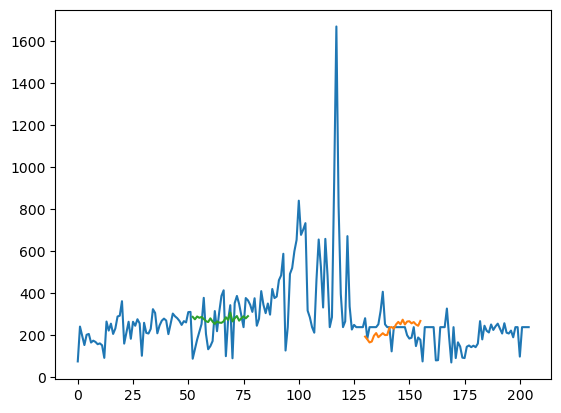

NEXT
DATASET INDEX  11
DATASET NUMBER  269221


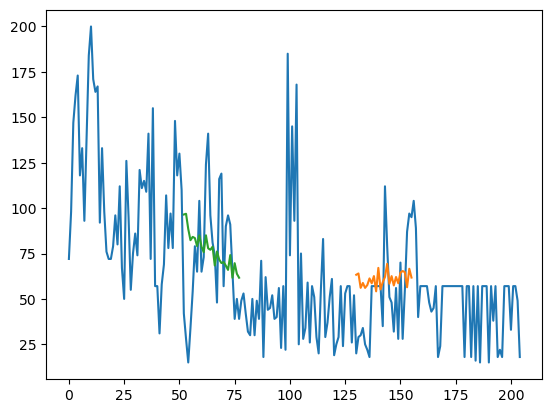

NEXT
DATASET INDEX  12
DATASET NUMBER  271177


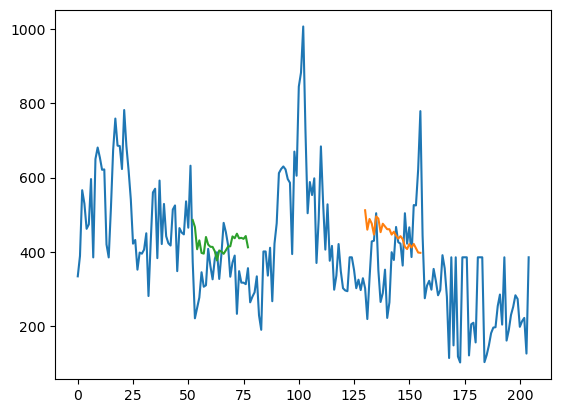

NEXT
DATASET INDEX  13
DATASET NUMBER  271179


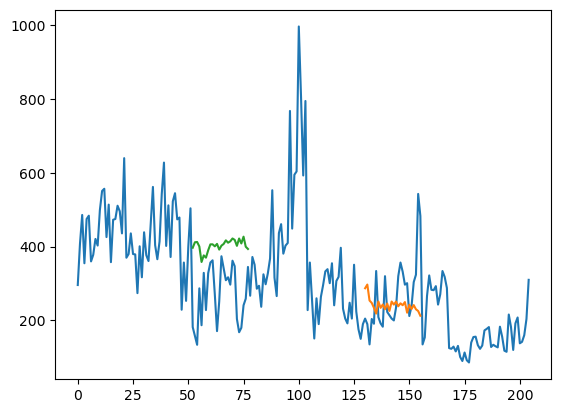

NEXT
DATASET INDEX  14
DATASET NUMBER  370801


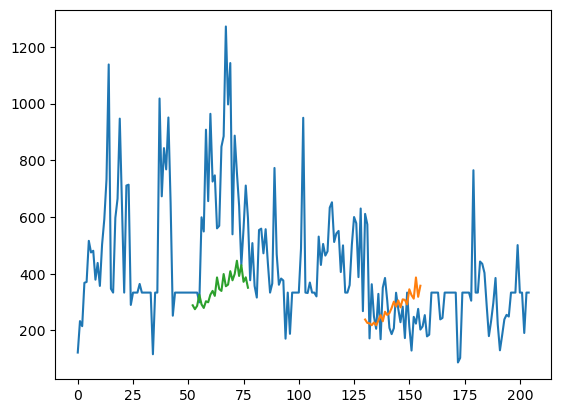

NEXT
DATASET INDEX  15
DATASET NUMBER  417538


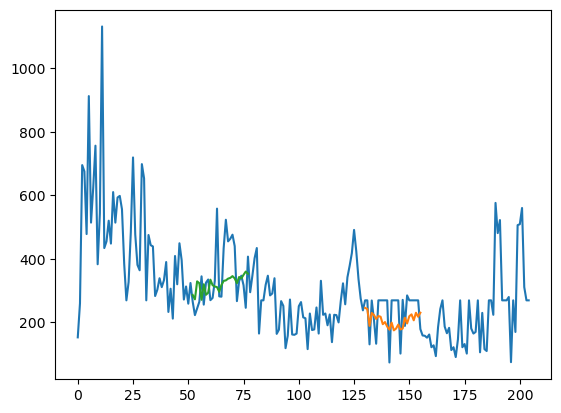

NEXT
DATASET INDEX  16
DATASET NUMBER  417622


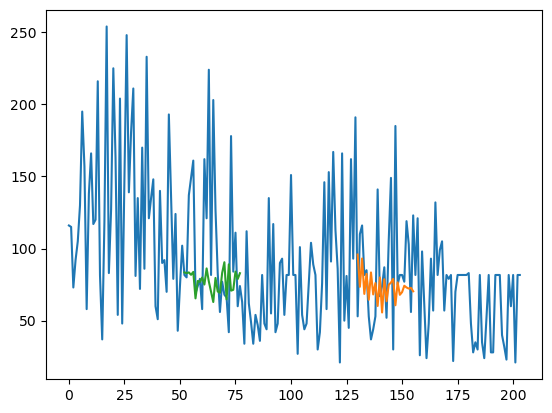

NEXT
DATASET INDEX  17
DATASET NUMBER  424390


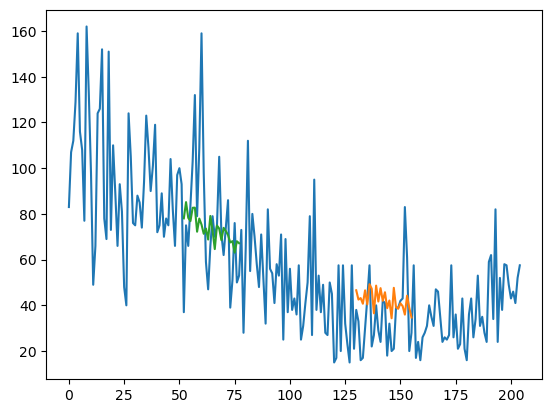

NEXT
DATASET INDEX  18
DATASET NUMBER  424391


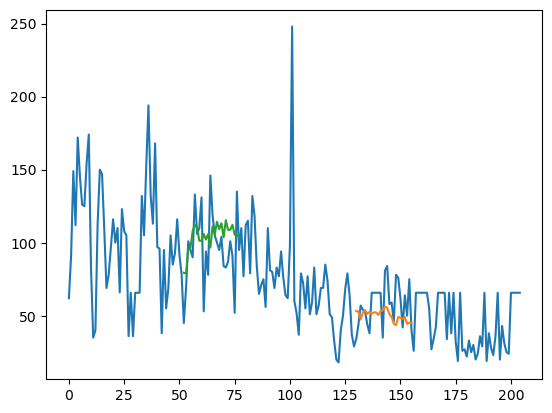

NEXT
DATASET INDEX  19
DATASET NUMBER  424479


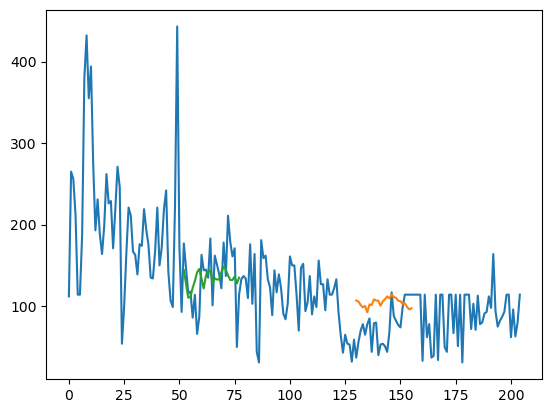

NEXT
DATASET INDEX  20
DATASET NUMBER  534571


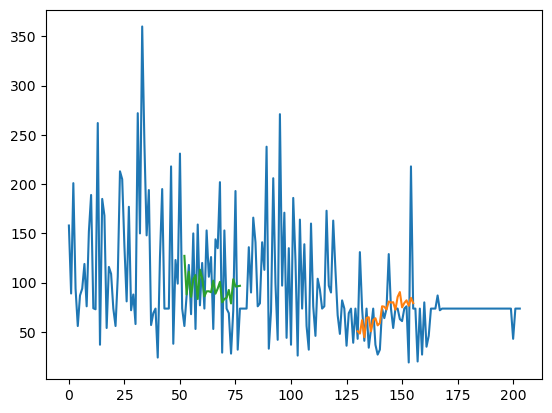

NEXT
DATASET INDEX  21
DATASET NUMBER  545488


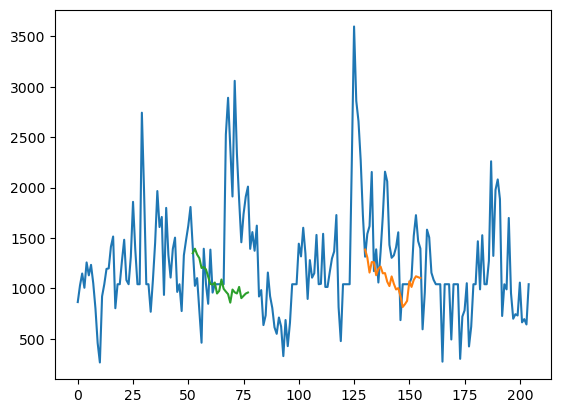

NEXT
DATASET INDEX  22
DATASET NUMBER  546924


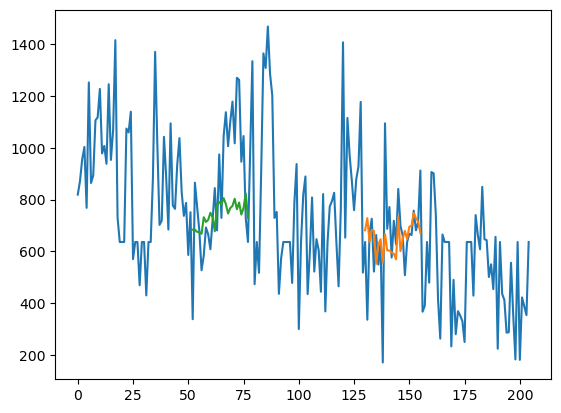

NEXT
DATASET INDEX  23
DATASET NUMBER  566393


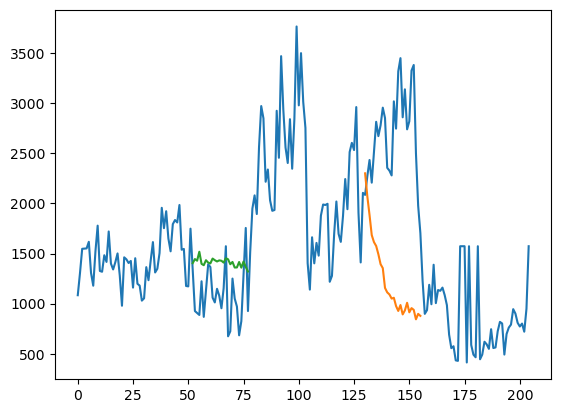

NEXT
DATASET INDEX  24
DATASET NUMBER  566394


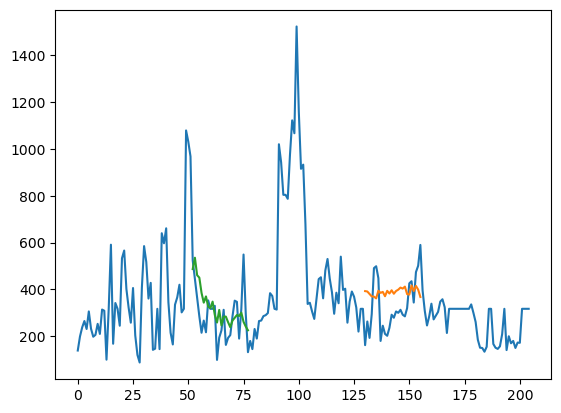

NEXT
DATASET INDEX  25
DATASET NUMBER  566395


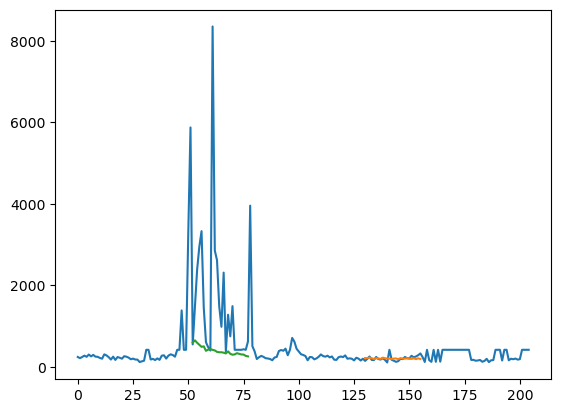

NEXT
DATASET INDEX  26
DATASET NUMBER  566409


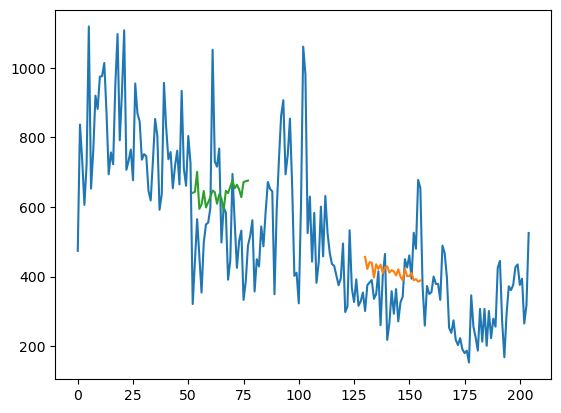

NEXT


In [223]:
for (idx, dataset) in enumerate(fullDataset) : 
    # print(dataset)
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot = [np.nan] * len(trainPredictPlot)
#     print(len(TrainDatasetPredictions[idx][0]), len(trainPredictPlot))
    trainPredictPlot[timestamp:len(TrainDatasetPredictions[idx][0])+timestamp] = TrainDatasetPredictions[idx,0,:]
    forecastingDepthIndexToPlot = 0
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot = [np.nan] * len(testPredictPlot)
    testPredictPlot[len(TrainDatasetPredictions[idx][0])+(timestamp*2)+forecastingHorizon+forecastingDepthIndexToPlot-1:len(dataset)-1] = TestDatasetPredictions[idx,forecastingDepthIndexToPlot,:]
    # print(len(TestDatasetPredictions[:,0]),len(trainPredict)+(timestamp*2)+1+forecastingHorizon, len(dataset)-1)
    print("DATASET INDEX ", idx)
    print("DATASET NUMBER ", datasetList[idx])
    plt.plot(dataset)
    plt.plot(testPredictPlot)
    plt.plot(trainPredictPlot)
    plt.show()
    print('NEXT')


In [219]:
for (idx, dataset) in enumerate(fullDataset) : 
    if (not(progressiveForecast)):
        for index in range (len(TrainDatasetPredictions[idx])):

            individualTrainInputsPlot = np.empty_like(dataset)
            individualTrainInputsPlot = [np.nan] * len(individualTrainInputsPlot)
            individualTrainInputsPlot[index:timestamp+index] = TrainDatasetInputs[idx,index]

            individualTrainPredictPlot = np.empty_like(dataset)
            individualTrainPredictPlot = [np.nan] * len(individualTrainPredictPlot)
            individualTrainPredictPlot[index+timestamp:timestamp+index+forecastingHorizon] = TrainDatasetPredictions[idx,index]

            plt.plot(dataset)
            plt.plot(individualTrainPredictPlot)
            plt.plot(individualTrainInputsPlot)
            plt.show()

forecastingHorizon 1 indirectForecastingHorizon  26
75038


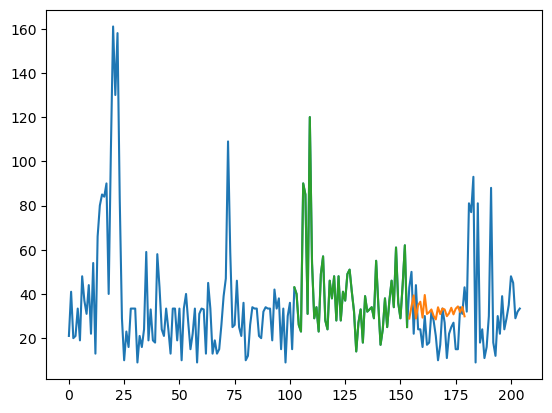

85843


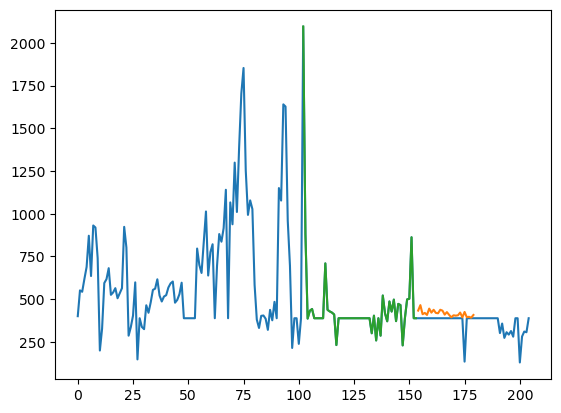

85861


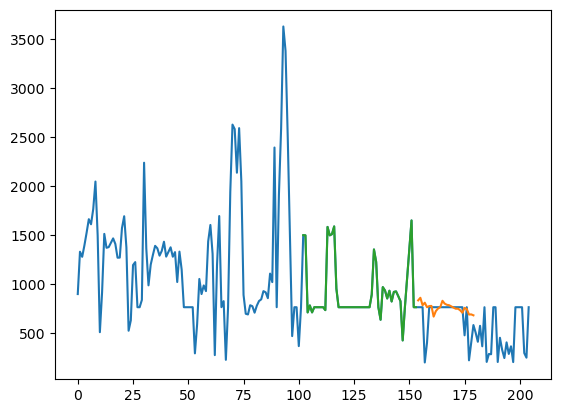

86040


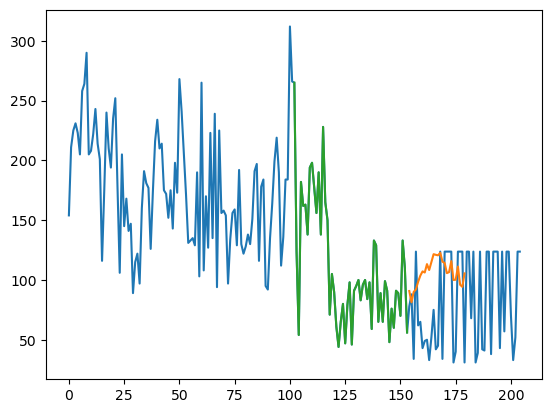

86543


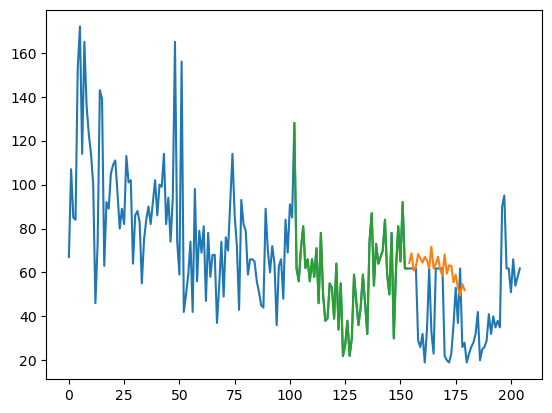

121216


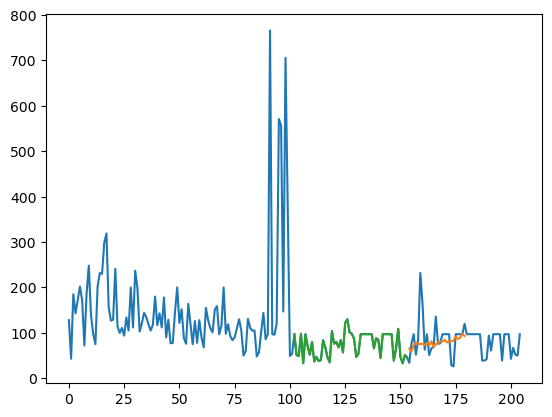

121397


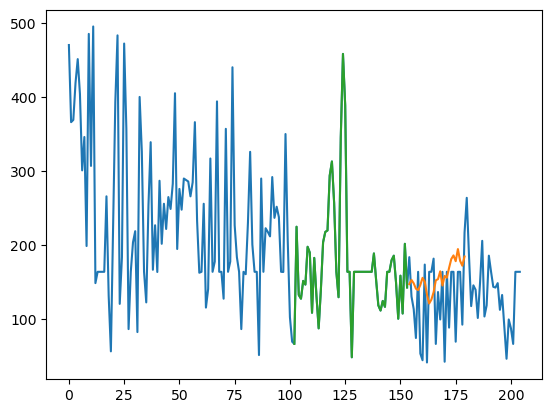

121457


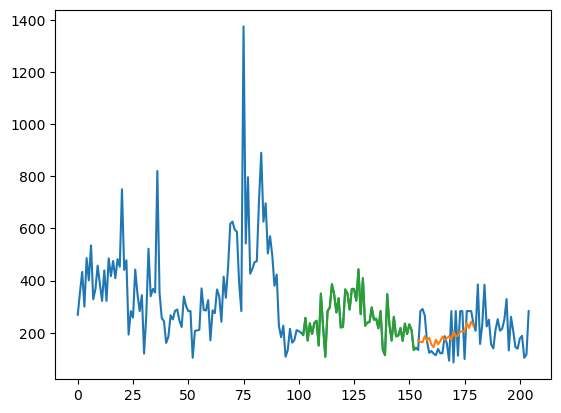

197456


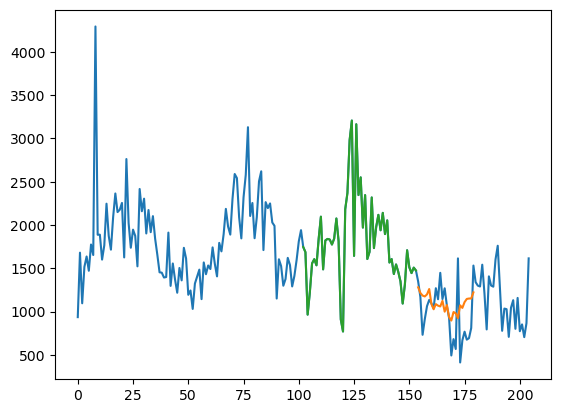

253059


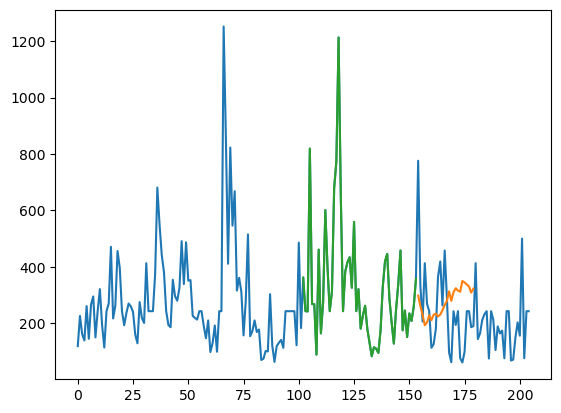

268987


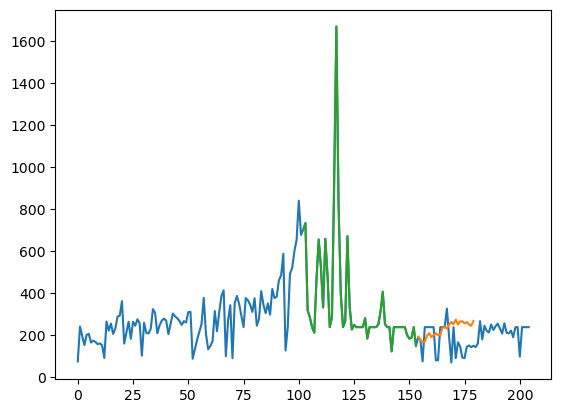

269221


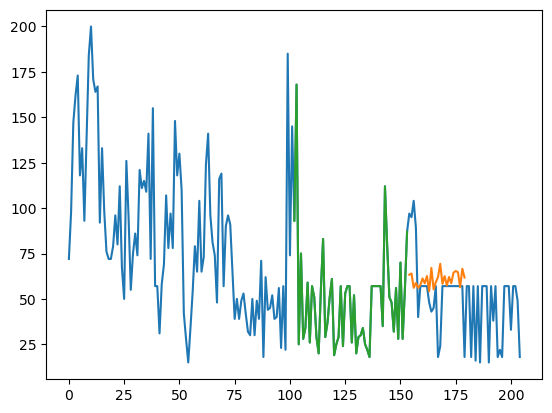

271177


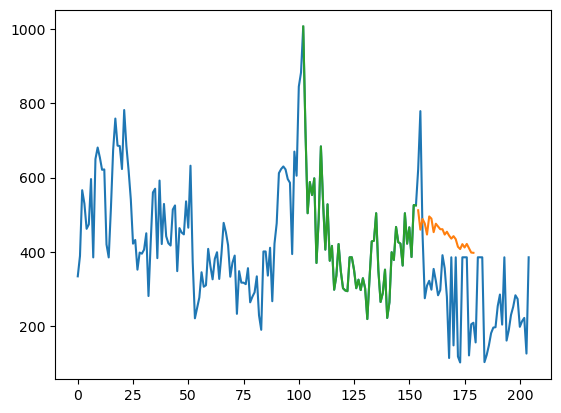

271179


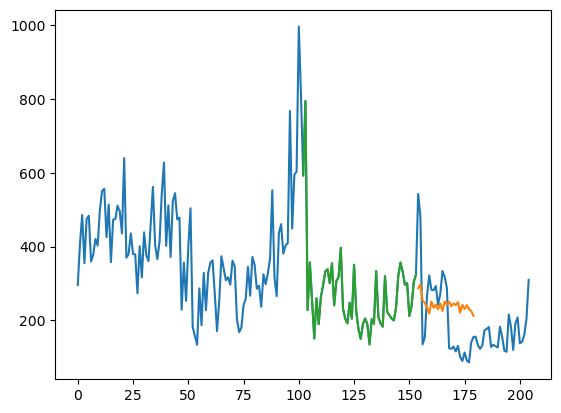

370801


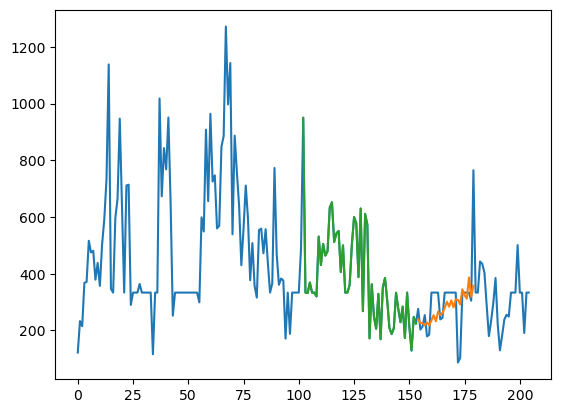

417538


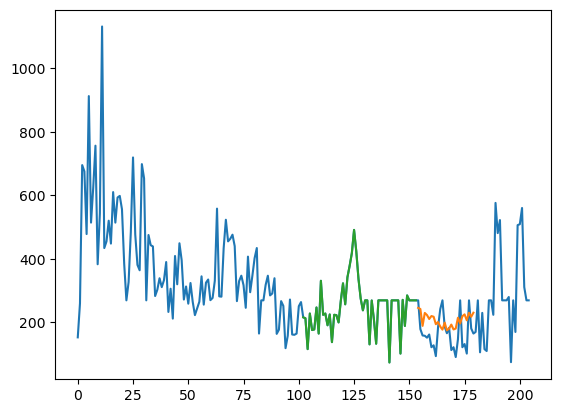

417622


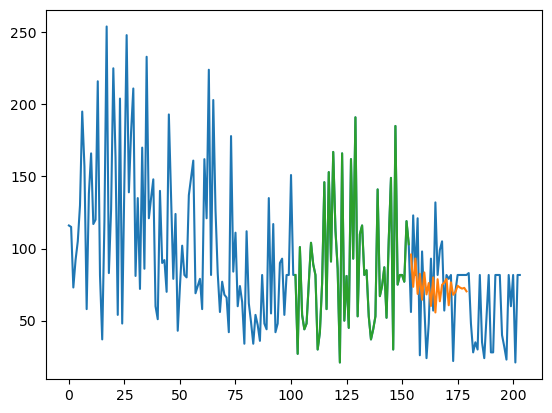

424390


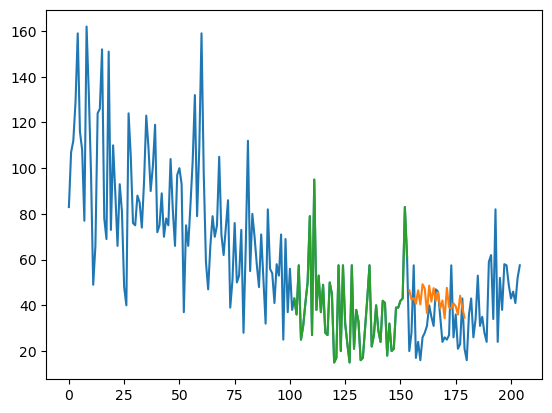

424391


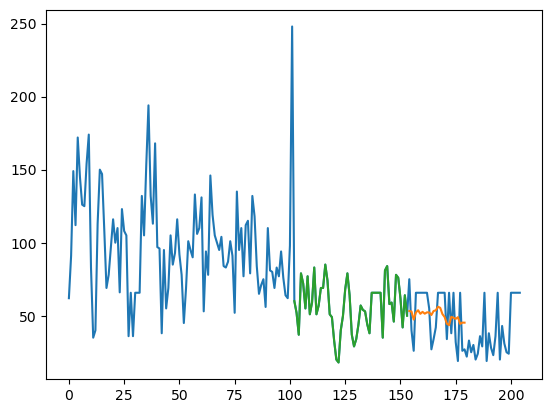

424479


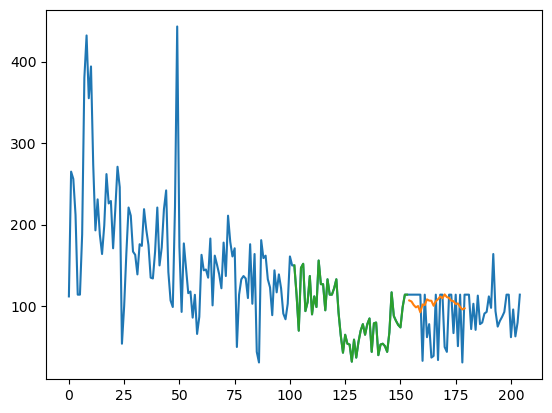

534571


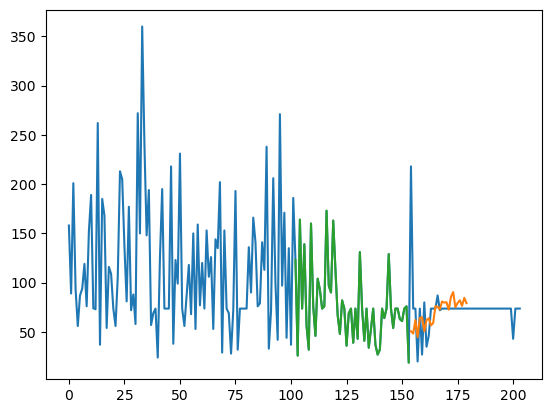

545488


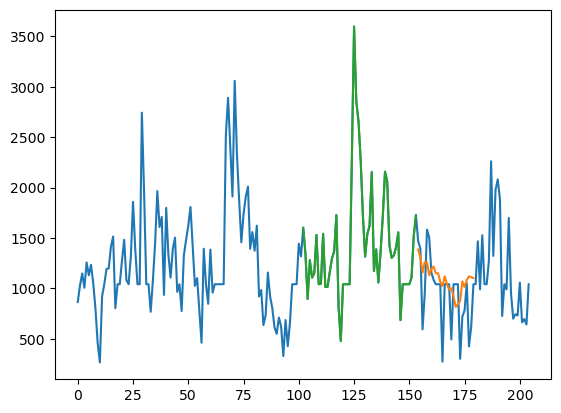

546924


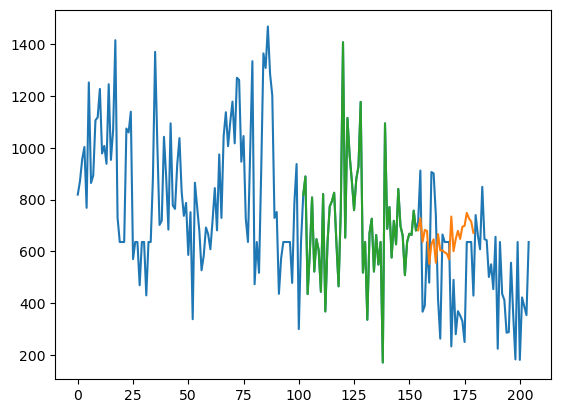

566393


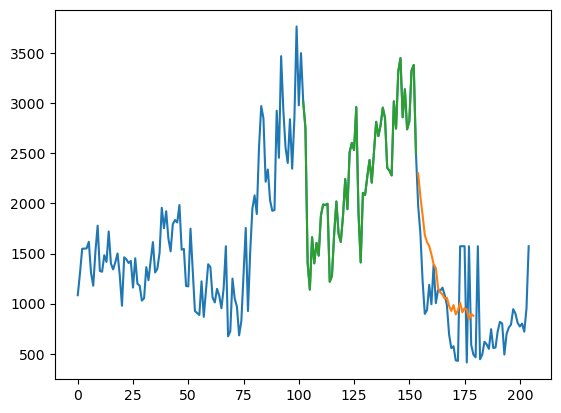

566394


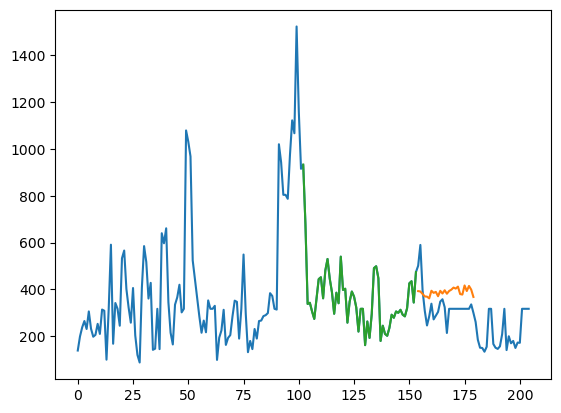

566395


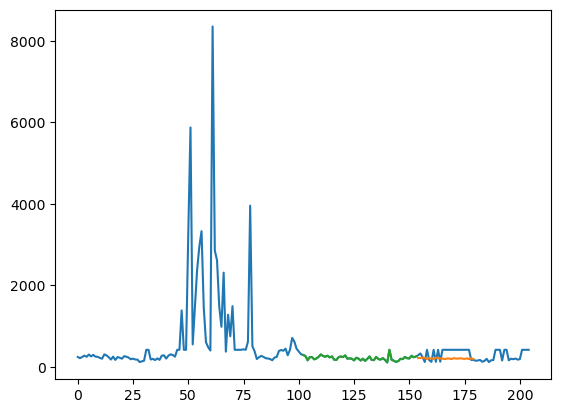

566409


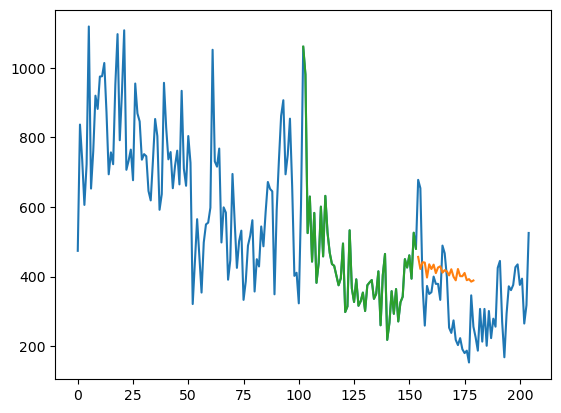

In [227]:
offset = 24
print("forecastingHorizon", forecastingHorizon, "indirectForecastingHorizon ", indirectForecastingHorizon)
for (idx, dataset) in enumerate(fullDataset) : 
    # print(TestDatasetPredictions[idx].shape)
    # for index in range (len(TestDatasetPredictions[idx])):
    for index in range (1):
        individualTestInputsPlot = np.empty_like(dataset)
        individualTestInputsPlot = [np.nan] * len(individualTestInputsPlot)
        # print(len(TrainDatasetPredictions[idx][0]))
        print(datasetList[idx])
        individualTestInputsPlot[len(TrainDatasetPredictions[idx][0])+index+timestamp+offset:len(TrainDatasetPredictions[idx])+index+timestamp*2+offset] = TestDatasetInputs[idx,index]
        individualTestPredictPlot = np.empty_like(dataset)
        individualTestPredictPlot = [np.nan] * len(individualTestPredictPlot)
        individualTestPredictPlot[len(TrainDatasetPredictions[idx][0])+index+timestamp*2+offset:len(TrainDatasetPredictions[idx])+index+2*timestamp+2*realForecastingHorizon-1+offset] = TestDatasetPredictions[idx,index]

        plt.plot(dataset)
        plt.plot(individualTestPredictPlot)
        plt.plot(individualTestInputsPlot)
        plt.show()

In [221]:
for (idx, dataset) in enumerate(fullDataset) : 
      print(datasetList[idx])
      resolution = 10
      deltaE = TrainDatasetPredictions[idx,0,:] - TrainDatasetOutputs[idx,0,:]
      maxValue = max(deltaE)
      minValue = min(deltaE)
      rangeSize = (maxValue - minValue)
      mean = np.mean(deltaE)
      variance = np.std(deltaE, ddof=1) 
      # offset = rangeSize / 2 + minValue
      offset = max(maxValue,-minValue)
      print(offset)
      # offset = mean
      deltaE_with_Offset = [x/offset for x in deltaE]

      # count, bins, ignored = plt.hist(deltaE_with_Offset, resolution, density=True)
      count, bins, ignored = plt.hist(deltaE_with_Offset, resolution, density=True)
      # plt.plot(bins, 1/(variance * np.sqrt(2 * np.pi)) *
      #             np.exp( - (bins - mean)**2 / (2 * variance**2) ),
      #       linewidth=2, color='r')

      plt.show()
      print("maxValue : ", maxValue," minValue : ",minValue," rangeSize : ",rangeSize," offset : ",offset," mean : ",mean," variance : ",variance)

75038


ValueError: operands could not be broadcast together with shapes (26,) (50,) 

In [ ]:
finalDelta = []
ListofResolution = [13,21,26,39,52]
for res in ListofResolution:
    print(res)
    for (idx, dataset) in enumerate(fullDataset) : 
        deltaE = TrainDatasetPredictions[idx,0,:] - TrainDatasetOutputs[idx,0,:]
        maxValue = max(deltaE)
        minValue = min(deltaE)
        rangeSize = (maxValue - minValue)
        mean = np.mean(deltaE)
        # variance = np.std(deltaE, ddof=1) 
        offset = max(maxValue,-minValue)
        # offset = mean
        sigma = math.sqrt(np.var(deltaE))
        # print(sigma)
        deltaE_with_Offset = [x / offset for x in deltaE]
        # deltaE_with_Offset_Normalized = [(x-mean)/sigma for x in deltaE_with_Offset]
        finalDelta.append(deltaE_with_Offset)
        # count, bins, ignored = plt.hist(deltaE_with_Offset, resolution, density=True)
        # print("maxValue : ", maxValue," minValue : ",minValue," rangeSize : ",rangeSize," offset : ",offset," mean : ",mean," variance : ",variance)
    count, bins, ignored = plt.hist(np.array(finalDelta).reshape(-1), res, density=True)
    plt.plot(bins, 1/(variance * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mean)**2 / (2 * variance**2) ),
          linewidth=2, color='r')
    plt.show()



13


ValueError: operands could not be broadcast together with shapes (26,) (50,) 

In [210]:
a = np.array([[[1, 2], [3, 4]]])
b = np.array([[[5, 6]]])
print(a.shape, b.shape)
np.concatenate((a, b), axis=1)

(1, 2, 2) (1, 1, 2)


array([[[1, 2],
        [3, 4],
        [5, 6]]])